In [34]:
#from little_helpers.p4_tools import get_final_markings_counts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import root, curve_fit, leastsq
import os
#coords_file = os.environ['HOME']+'/Dropbox/p4_analysis/inca_city_corners.csv'
#path2regional_data = os.environ['HOME']+'/Dropbox/p4_analysis/for_chase/'
from planet4 import io, region_data, markings

In [35]:
''' defining input: input is a list of filenames as strings ('filename.csv'). 
input can contain information for one or more regions. For 1 region, input should contain that region's fan file, 
followed by the season 2 metadata for that region, followed by the season 3 metadata for that region, 
followed by that region's blotches file. For more than 1 region, add more filenames in the same order. 
'''
_input_Giza = ['giza_fans.csv','giza_season2_metadata.csv','giza_season3_metadata.csv','giza_blotches.csv']
_input_Inca = ['Inca_seasons23_fans.csv','inca_season2_metadata.csv','inca_season3_metadata.csv','Inca_seasons23_blotches.csv']
_input_Ithaca = ['ithaca_fans.csv','ithaca_season2_metadata.csv','ithaca_season3_metadata.csv','ithaca_blotches.csv']
_input_Manh = ['manhattan_fans.csv','manhattan_season2_metadata.csv','manhattan_season3_metadata.csv','manhattan_blotches.csv']

In [36]:
def get_regions(_input_):
    '''get_regions creates a dataframe to help step through the processes below. 
    note that fan and blotch file names must be identical to the ones following 
    these "if" statements for the function to recognize them properly'''
    regions = pd.DataFrame(np.zeros((4,(len(_input_)//4))))
    for i in range(len(_input_)//4):
        if _input_[i*4]=='giza_fans.csv':
            regions.loc[0,i] = _input_[i*4]
            regions.loc[1,i] = _input_[i*4+1]
            regions.loc[2,i] = _input_[i*4+2]
            regions.loc[3,i] = _input_[i*4+3]
            regions.loc[4,i] = 'Giza'
        elif _input_[i*4]=='Inca_seasons23_fans.csv':
            regions.loc[0,i] = _input_[i*4]
            regions.loc[1,i] = _input_[i*4+1]
            regions.loc[2,i] = _input_[i*4+2]
            regions.loc[3,i] = _input_[i*4+3]
            regions.loc[4,i] = 'Inca City'
        elif _input_[i*4]=='ithaca_fans.csv':
            regions.loc[0,i] = _input_[i*4]
            regions.loc[1,i] = _input_[i*4+1]
            regions.loc[2,i] = _input_[i*4+2]
            regions.loc[3,i] = _input_[i*4+3]
            regions.loc[4,i] = 'Ithaca'
        elif _input_[i*4]=='manhattan_fans.csv':
            regions.loc[0,i] = _input_[i*4]
            regions.loc[1,i] = _input_[i*4+1]
            regions.loc[2,i] = _input_[i*4+2]
            regions.loc[3,i] = _input_[i*4+3]
            regions.loc[4,i] = 'Manhattan'
    return regions

In [37]:
regions = get_regions(_input_Ithaca)
regions

,0
0,ithaca_fans.csv
1,ithaca_season2_metadata.csv
2,ithaca_season3_metadata.csv
3,ithaca_blotches.csv
4,Ithaca


In [38]:
# read out metadata for season 2 and 3
s2_meta = pd.read_csv(regions[0][1])
s3_meta = pd.read_csv(regions[0][2])

# delete column with path - we don't use it and add columns for numbers of fans and blotches


# make columns for number of fans and blotches
s2_meta['nr_fans_filtred'] = 0
s2_meta['nr_blot_filtred'] = 0
s3_meta['nr_fans_filtred'] = 0
s3_meta['nr_blot_filtred'] = 0

# read out actual markings for fans and blotches, both seasons combined
fans = pd.read_csv(regions[0][0])
blotches = pd.read_csv(regions[0][3])

# find unique obsids in the fans and blotches catalogs
fimg_names = fans.image_name.unique()
bimg_names = blotches.image_name.unique()

In [39]:
# add column for season flag and validity of marking
fans['season'] = 0
fans['valid_marking'] = True
blotches['season'] = 0
blotches['valid_marking'] = True
blotches['area'] = np.pi * blotches.radius_1 * blotches.radius_2 / 4

# define column for season flag
fans.season[fans.obsid.str[5] == '1'] = 2
fans.season[fans.obsid.str[5] == '2'] = 3
blotches.season[blotches.obsid.str[5] == '1'] = 2
blotches.season[blotches.obsid.str[5] == '2'] = 3

/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveSh

In [40]:
# find what size fans should be removed for fair comparison
min_fan_pixels = fans.distance.min()
min_bl_area = blotches.area.min()

max_scale = np.max( (s2_meta.map_scale.max(), s3_meta.map_scale.max() ) )
print('maximum map_scale:',  max_scale, '; min_fan_marking:', min_fan_pixels, '; min_bl_area:', min_bl_area)

# if the minimal fan marking tool is = 10 pixels at max_bin = 4, it will correspond to  
# min_fan_pixels * max_binning / image_binning
s2_meta['min_fan'] = min_fan_pixels * s2_meta.map_scale.max() // s2_meta.map_scale + 1
s3_meta['min_fan'] = min_fan_pixels * s3_meta.map_scale.max() // s3_meta.map_scale + 1

# if the minimal blotch marking tool is = 80 sq. pixels at max_bin = 4, it will correspond to  
# min_bl_area * max_binning^2 / image_binning^2
s2_meta['min_bl'] = min_bl_area * s2_meta.map_scale.max()**2 // s2_meta.map_scale**2 + 1
s3_meta['min_bl'] = min_bl_area * s3_meta.map_scale.max()**2 // s3_meta.map_scale**2 + 1

maximum map_scale: 1.0 ; min_fan_marking: 10.0 ; min_bl_area: 78.5398163397


In [41]:
# mark "valid_marking" key to be False for blotch markings smaller than min_bl for that image
print(len(blotches))
for i in range(len(blotches)):
    if (blotches.season[i] == 2): 
        nr_image =  np.where(s2_meta.obsid == blotches.obsid[i])[0][0]        
        min_b = s2_meta.min_bl[ nr_image  ]         
        if (blotches.area[i] < min_b ):
            blotches.valid_marking[i] = False
    if (blotches.season[i] == 3): 
        nr_image =  np.where(s3_meta.obsid == blotches.obsid[i])[0][0]        
        min_bl = s3_meta.min_bl[ nr_image  ]         
        if (blotches.area[i] < min_b ):
            blotches.valid_marking[i] = False

/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


18045


/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [42]:
# mark "valid_marking" key to be False for fan markings smaller than min_fan for that image
for i in range(len(fans)):
    if (fans.season[i] == 2): 
        nr_image =  np.where(s2_meta.obsid == fans.obsid[i])[0][0]        
        min_f = s2_meta.min_fan[ nr_image  ]         
        if (fans.distance[i] < min_f ):
            fans.valid_marking[i] = False
    if (fans.season[i] == 3): 
        nr_image =  np.where(s3_meta.obsid == fans.obsid[i])[0][0]        
        min_f = s3_meta.min_fan[ nr_image  ]         
        if (fans.distance[i] < min_f ):
            fans.valid_marking[i] = False

/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [43]:
# remove small markings from the counts of fans and blotches for season 2
for i in range(len(s2_meta)):
    oi = s2_meta.obsid[i]
    # sub-data_frame with only fans for this obsid:
    fans_oi = fans[fans.obsid == oi]
    nr_fans = len(fans_oi)
    small_fans = len(fans_oi[fans_oi.valid_marking == False] )
    s2_meta['nr_fans_filtred'][i] = nr_fans - small_fans
    
    # sub-data_frame with only blotches for this obsid:
    blot_oi = blotches[blotches.obsid == oi]
    nr_blots = len(blot_oi)
    small_bls = len(blot_oi[blot_oi.valid_marking == False] )
    s2_meta['nr_blot_filtred'][i] = nr_blots - small_bls

/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
# remove small markings from the counts of fans and blotches for season 3
for i in range(len(s3_meta)):
    oi = s3_meta.obsid[i]
    # sub-data_frame with only fans for this obsid:
    fans_oi = fans[fans.obsid == oi]
    nr_fans = len(fans_oi)
    small_fans = len(fans_oi[fans_oi.valid_marking == False] )
    s3_meta['nr_fans_filtred'][i] = nr_fans - small_fans
    
    # sub-data_frame with only blotches for this obsid:
    blot_oi = blotches[blotches.obsid == oi]
    nr_blots = len(blot_oi)
    small_bls = len(blot_oi[blot_oi.valid_marking == False] )
    s3_meta['nr_blot_filtred'][i] = nr_blots - small_bls

/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
# scale nr markings with image area
s2_meta['nr_fans_scaled'] = s2_meta.nr_fans_filtred / (s2_meta.real_area*1e-6)
s3_meta['nr_fans_scaled'] = s3_meta.nr_fans_filtred / (s3_meta.real_area*1e-6)
s2_meta['nr_bls_scaled'] = s2_meta.nr_blot_filtred / (s2_meta.real_area*1e-6)
s3_meta['nr_bls_scaled'] = s3_meta.nr_blot_filtred / (s3_meta.real_area*1e-6)

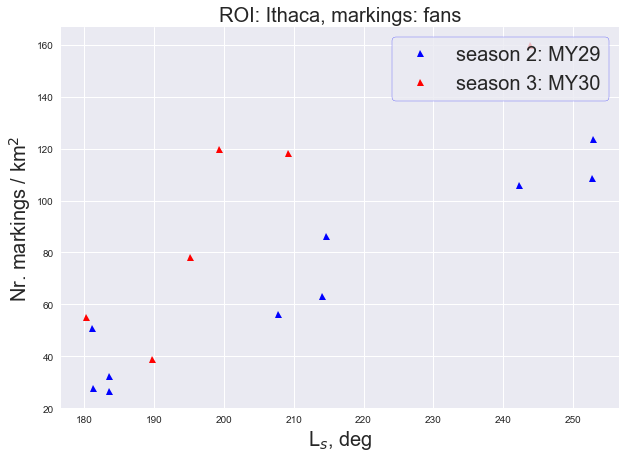

In [46]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=( 10,7))
plt.plot(s2_meta.l_s, s2_meta.nr_fans_scaled, 'b^',label='season 2: MY29')
plt.plot(s3_meta.l_s, s3_meta.nr_fans_scaled, 'r^', label='season 3: MY30')

ax.set_title('ROI: '+regions.loc[4,0]+', markings: fans', fontsize=20)
ax.set_xlabel('L$_s$, deg', fontsize=20)
ax.set_ylabel('Nr. markings / km$^2$', fontsize=20)
ax.legend(loc='upper right', fontsize=20, frameon= True, edgecolor='b')
plt.show()
#plt.savefig(os.environ['HOME'] +'/Dropbox/DrB_Images/my_plots/planet4_results/'+regions.loc[4,0]+'_fan_counts_s23.png')

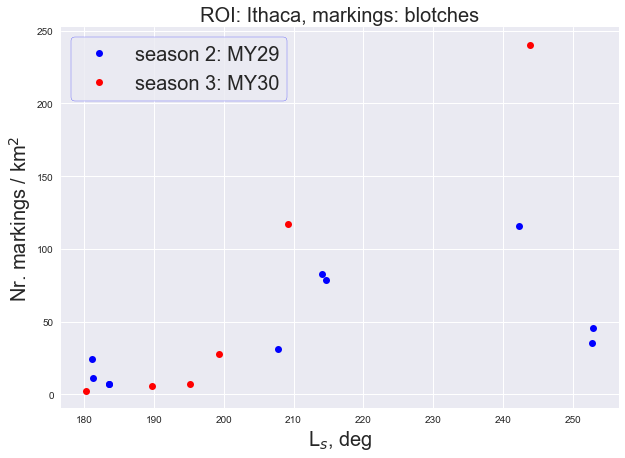

In [47]:
plt.rcParams.update({'font.size': 16})
fig1, ax = plt.subplots(figsize=( 10,7))
plt.plot(s2_meta.l_s, s2_meta.nr_bls_scaled, 'bo',label='season 2: MY29')
plt.plot(s3_meta.l_s, s3_meta.nr_bls_scaled, 'ro', label='season 3: MY30')

ax.set_title('ROI: '+regions.loc[4,0]+', markings: blotches', fontsize=20)
ax.set_xlabel('L$_s$, deg', fontsize=20)
ax.set_ylabel('Nr. markings / km$^2$', fontsize=20)
ax.legend(loc='upper left', fontsize=20, frameon= True, edgecolor='b')
#ax.set_ylim((0,30))
plt.show()
#plt.savefig(os.environ['HOME'] +'/Dropbox/DrB_Images/my_plots/planet4_results/'+regions.loc[4,0]+'_blo_counts_s23.png')

In [48]:
s3_meta

,binning,invalids,l_s,line_samples,lines,map_scale,obsid,path,real_area,nr_fans_filtred,nr_blot_filtred,min_fan,min_bl,nr_fans_scaled,nr_bls_scaled
0,2,0.783569,243.829437,20902,31677,0.25,ESP_021491_0950,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,8.956342e+06,1434,2154,41.0,1257.0,160.110018,240.499985
1,4,0.807959,209.241491,24062,35640,0.25,ESP_020779_0950,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.029301e+07,1218,1208,41.0,1257.0,118.332742,117.361209
2,2,0.859031,199.362248,16919,26284,0.50,ESP_020568_0950,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.567216e+07,1881,434,21.0,315.0,120.021711,27.692410
3,4,0.867697,195.125296,20428,24357,0.50,ESP_020476_0950,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.645728e+07,1289,120,21.0,315.0,78.324001,7.291606
4,4,0.934963,189.712746,41552,68971,0.50,ESP_020357_0950,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,4.659705e+07,1807,278,21.0,315.0,38.779280,5.966043
5,4,0.935496,180.310799,20344,34894,1.00,ESP_020146_0950,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,4.579014e+07,2516,121,11.0,79.0,54.946329,2.642490


In [49]:
s2_meta

,binning,invalids,l_s,line_samples,lines,map_scale,obsid,path,real_area,nr_fans_filtred,nr_blot_filtred,min_fan,min_bl,nr_fans_scaled,nr_bls_scaled
0,4,0.697588,181.205092,8168,37649,0.50,ESP_011350_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,2.324924e+07,1180,569,21.0,315.0,50.754338,24.473914
1,4,0.949823,181.249083,30049,40496,1.00,ESP_011351_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,6.105878e+07,1686,680,11.0,79.0,27.612736,11.136809
2,4,0.839674,183.549487,14771,45258,0.50,ESP_011403_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,2.679465e+07,718,197,21.0,315.0,26.796391,7.352213
3,4,0.949826,183.593752,34927,37137,1.00,ESP_011404_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,6.508053e+07,2120,458,11.0,79.0,32.575028,7.037435
4,4,0.857744,207.750946,16916,26537,0.50,ESP_011931_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.596468e+07,898,499,21.0,315.0,56.249165,31.256496
5,2,0.813308,214.019732,25791,34943,0.25,ESP_012063_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.051562e+07,665,873,41.0,1257.0,63.239231,83.019321
6,2,0.801023,214.641238,22962,36382,0.25,ESP_012076_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.038915e+07,895,820,41.0,1257.0,86.147596,78.928524
7,2,0.800849,242.278661,22904,36401,0.25,ESP_012643_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.037737e+07,1099,1199,41.0,1257.0,105.903487,115.539837
8,2,0.802876,252.710250,11634,18186,0.50,ESP_012854_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.042665e+07,1135,366,21.0,315.0,108.855643,35.102348
9,2,0.821805,252.907035,14854,16089,0.50,ESP_012858_0855,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.064651e+07,1316,484,21.0,315.0,123.608635,45.460927
